In [111]:
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, matthews_corrcoef, confusion_matrix

y_true = np.load('y_true.npy')
y_pred_sl = np.load('y_preds_sl.npy')
y_pred_mpl = np.load('y_preds_mpl.npy')
fpr_sl, tpr_sl, thr_sl = roc_curve(y_true, y_pred_sl)
fpr_mpl, tpr_mpl, thr_mpl = roc_curve(y_true, y_pred_mpl)

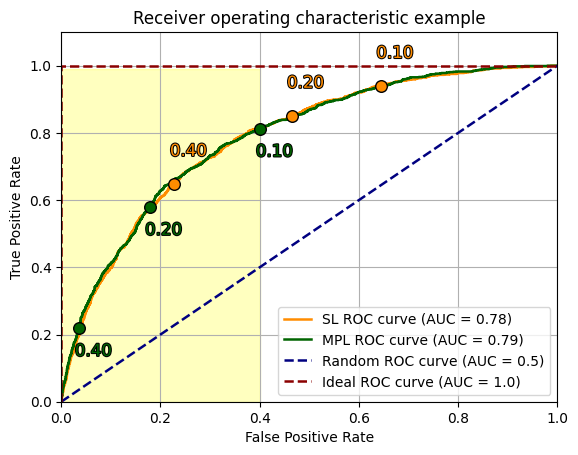

In [112]:
from matplotlib import pyplot as plt
from matplotlib import patheffects

plt.figure()
lw = 1.8
plt.plot(fpr_sl, tpr_sl, color='darkorange',
         lw=lw, label='SL ROC curve (AUC = %0.2f)' % auc(fpr_sl, tpr_sl))
plt.plot(fpr_mpl, tpr_mpl, color='darkgreen',
        lw=lw, label='MPL ROC curve (AUC = %0.2f)' % auc(fpr_mpl, tpr_mpl))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random ROC curve (AUC = 0.5)')
plt.plot([0, 0, 1], [0, 1, 1], color='darkred', lw=lw, linestyle='--', label='Ideal ROC curve (AUC = 1.0)')

for threshold in [0.1, 0.2, 0.4]:
    # Find the closest threshold index in SL curve
        idx_sl = np.argmin(np.abs(thr_sl - threshold))
        text = plt.annotate(f'{threshold:.2f}', (fpr_sl[idx_sl], tpr_sl[idx_sl]), 
                     textcoords="offset points", xytext=(10,20), ha='center', 
                     color='darkorange', fontsize=12)
        text.set_path_effects([patheffects.withStroke(linewidth=1.5, foreground='black')])
        plt.scatter(fpr_sl[idx_sl], tpr_sl[idx_sl], color='darkorange',
                    edgecolors='black', s=70, zorder=10)

        # Find the closest threshold index in MPL curve
        idx_mpl = np.argmin(np.abs(thr_mpl - threshold))
        text = plt.annotate(f'{threshold:.2f}', (fpr_mpl[idx_mpl], tpr_mpl[idx_mpl]), 
                     textcoords="offset points", xytext=(10,-20), ha='center', 
                     color='darkgreen', fontsize=12)
        text.set_path_effects([patheffects.withStroke(linewidth=1.5, foreground='black')])
        plt.scatter(fpr_mpl[idx_mpl], tpr_mpl[idx_mpl], color='darkgreen',
                    edgecolors='black', s=70, zorder=10)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.axvspan(0, 0.4, 0.0, 0.9, color='yellow', alpha=0.25)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.savefig('roc-auc.png', dpi=800)
plt.show()

In [113]:
import numpy as np

def find_threshold_for_fpr(fpr_sl, thr_sl, fpr_mpl, thr_mpl, target_fpr):
    """
    Find the closest threshold for a given FPR for both models.

    Parameters:
    - fpr_sl: Array of FPR values for the SL model.
    - thr_sl: Array of threshold values for the SL model.
    - fpr_mpl: Array of FPR values for the MPL model.
    - thr_mpl: Array of threshold values for the MPL model.
    - target_fpr: The target FPR value.

    Returns:
    A tuple containing the closest thresholds for the SL and MPL models.
    """
    # Find the index of the closest FPR to the target for each model
    idx_sl = np.argmin(np.abs(fpr_sl - target_fpr))
    idx_mpl = np.argmin(np.abs(fpr_mpl - target_fpr))

    # Retrieve the corresponding thresholds
    threshold_sl = thr_sl[idx_sl]
    threshold_mpl = thr_mpl[idx_mpl]

    return threshold_sl, threshold_mpl

# Example usage
target_fpr = 0.2  # Define your target FPR here
# You need to have fpr_sl, thr_sl, fpr_mpl, thr_mpl defined as per your ROC calculation
threshold_sl, threshold_mpl = find_threshold_for_fpr(fpr_sl, thr_sl, fpr_mpl, thr_mpl, target_fpr)
print(f"SL model threshold: {threshold_sl}, MPL model threshold: {threshold_mpl}")

SL model threshold: 0.4318883717060089, MPL model threshold: 0.1839415729045868


In [114]:
y_pred_sl_bin = (y_pred_sl > threshold_sl).astype(int)
y_pred_mpl_bin = (y_pred_mpl > threshold_mpl).astype(int)
matt_coeff_sl = matthews_corrcoef(y_true, y_pred_sl_bin)
matt_coeff_mpl = matthews_corrcoef(y_true, y_pred_mpl_bin)
print(f"Matthews correlation coefficient for SL model: {matt_coeff_sl}")
print(f"Matthews correlation coefficient for MPL model: {matt_coeff_mpl}")

Matthews correlation coefficient for SL model: 0.2969802702774128
Matthews correlation coefficient for MPL model: 0.31167593864728244


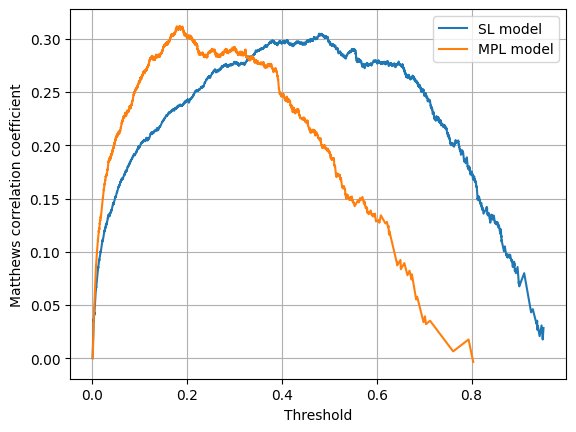

In [119]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_mcc(y_true, y_pred_probs, thresholds):
    """
    Calculate Matthews correlation coefficient for different thresholds.

    Parameters:
    - y_true: Array of true binary labels.
    - y_pred_probs: Array of predicted probabilities for the positive class.
    - thresholds: List of threshold values to evaluate.

    Returns:
    A dictionary mapping each threshold to its MCC.
    """
    mcc_scores = {}
    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate MCC
        denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = 0 if denominator == 0 else (tp * tn - fp * fn) / denominator
        
        mcc_scores[threshold] = mcc
    
    return mcc_scores

mcc_scores_sl = calculate_mcc(y_true, y_pred_sl, thr_sl)
mcc_scores_mpl = calculate_mcc(y_true, y_pred_mpl, thr_mpl)
plt.plot()
plt.plot(thr_sl, list(mcc_scores_sl.values()), label='SL model')
plt.plot(thr_mpl, list(mcc_scores_mpl.values()), label='MPL model')
plt.xlabel('Threshold')
plt.ylabel('Matthews correlation coefficient')
plt.legend()
plt.grid()
plt.savefig('mcc.png', dpi=800)
plt.show()


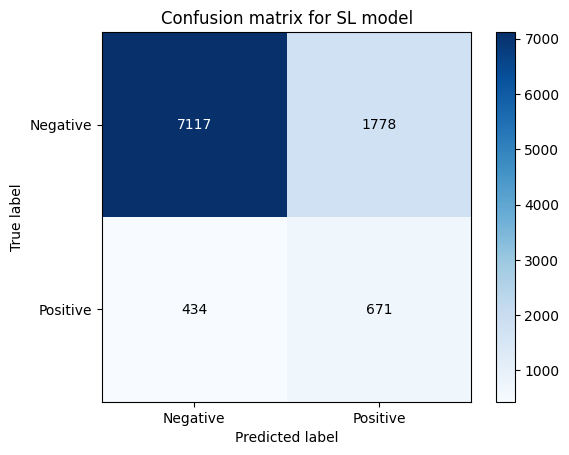

In [120]:
conf_matrix_sl = confusion_matrix(y_true, y_pred_sl_bin)
plt.plot()
plt.imshow(conf_matrix_sl, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion matrix for SL model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.text(0, 0, conf_matrix_sl[0, 0], ha='center', va='center', color='white')
plt.text(0, 1, conf_matrix_sl[1, 0], ha='center', va='center', color='black')
plt.text(1, 0, conf_matrix_sl[0, 1], ha='center', va='center', color='black')
plt.text(1, 1, conf_matrix_sl[1, 1], ha='center', va='center', color='black')
plt.savefig('confusion-matrix-sl.png', dpi=800)
plt.show()

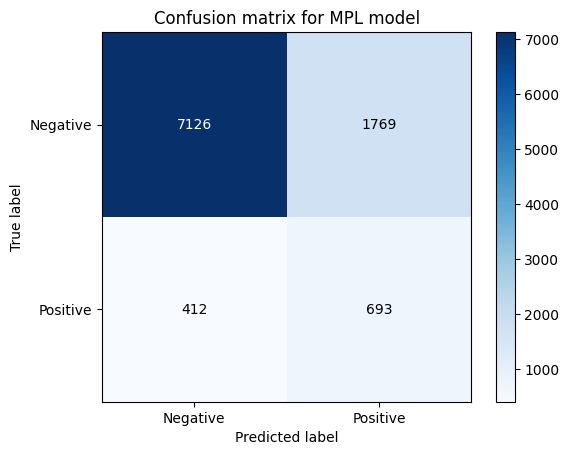

In [121]:
conf_matrix_mpl = confusion_matrix(y_true, y_pred_mpl_bin)
plt.plot()
plt.imshow(conf_matrix_mpl, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion matrix for MPL model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.text(0, 0, conf_matrix_mpl[0, 0], ha='center', va='center', color='white')
plt.text(0, 1, conf_matrix_mpl[1, 0], ha='center', va='center', color='black')
plt.text(1, 0, conf_matrix_mpl[0, 1], ha='center', va='center', color='black')
plt.text(1, 1, conf_matrix_mpl[1, 1], ha='center', va='center', color='black')
plt.savefig('confusion-matrix-mpl.png', dpi=800)
plt.show()